In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tu API key de Alpha Vantage
api_key = 'LFQQIV3LD5O20Q7P'
ticker = 'AAPL'


In [2]:
# Balance Sheet
def get_balance_sheet(ticker):
    url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticker}&apikey={api_key}'
    r = requests.get(url)
    data = r.json()
    return pd.DataFrame(data['annualReports'])

# Income Statement
def get_income_statement(ticker):
    url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticker}&apikey={api_key}'
    r = requests.get(url)
    data = r.json()
    return pd.DataFrame(data['annualReports'])

# Cash Flow
def get_cash_flow(ticker):
    url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticker}&apikey={api_key}'
    r = requests.get(url)
    data = r.json()
    return pd.DataFrame(data['annualReports'])


In [3]:
def preparar_datos_avanzado(ticker):
    bs = get_balance_sheet(ticker)
    is_ = get_income_statement(ticker)
    cf = get_cash_flow(ticker)

    for df in [bs, is_, cf]:
        df.set_index('fiscalDateEnding', inplace=True)
        df.sort_index(inplace=True)
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    ni = is_['netIncome']
    revenue = is_['totalRevenue']
    cfo = cf['operatingCashflow']
    capex = cf['capitalExpenditures']
    total_assets = bs['totalAssets']

    accruals = ni - cfo
    delta_accruals = accruals.diff()
    avg_assets = (total_assets + total_assets.shift(1)) / 2
    sloan_ratio = delta_accruals / avg_assets
    ccr = cfo / ni
    capex_cfo = capex / cfo
    tata = (ni - cfo) / total_assets
    m_score = -4.84 + 4.679 * tata

    df = pd.DataFrame({
        'Revenue': revenue,
        'Net Income': ni,
        'CFO': cfo,
        'CapEx': capex,
        'Sloan Ratio': sloan_ratio,
        'CCR': ccr,
        'CapEx/CFO': capex_cfo,
        'Beneish M-Score': m_score
    })

    return df.dropna()


In [4]:
def plot_calidad_ganancias(df):
    df[['Growth NI (%)', 'Growth CFO (%)']].plot(kind='bar', figsize=(10,6), title="Crecimiento CFO vs Net Income")
    plt.axhline(0, color='black', linewidth=1)
    plt.tight_layout()
    plt.show()

    df['Sloan Ratio'].plot(kind='bar', title="Sloan Ratio (Accruals/Assets)", figsize=(10,6))
    plt.axhline(0, color='black', linewidth=1)
    plt.tight_layout()
    plt.show()


In [5]:
def calcular_ccr(df):
    df['CCR'] = df['CFO'] / df['Net Income']
    return df


In [6]:
def calcular_beneish(df, bs, is_):
    # Requiere ventas y activos totales para TATA
    total_assets = bs['totalAssets']
    ni = is_['netIncome']
    cfo = df['CFO']

    # TATA = (NI - CFO) / Total Assets
    tata = (ni - cfo) / total_assets

    # Solo una versión simplificada del M-Score usando TATA
    m_score = -4.84 + 4.679 * tata.fillna(0)

    df['TATA'] = tata
    df['Beneish M-Score'] = m_score
    return df


In [7]:
def color_semaforo(val, metric):
    
    if metric == 'Sloan Ratio':
        if val > 0.15:
            return 'background-color: red'
        elif val > 0.10:
            return 'background-color: yellow'
        else:
            return 'background-color: lightgreen'

    elif metric == 'CCR':
        if val < 0.8:
            return 'background-color: red'
        elif val < 1.0:
            return 'background-color: yellow'
        else:
            return 'background-color: lightgreen'

    elif metric == 'Beneish M-Score':
        if val > -1.78:
            return 'background-color: red'
        elif val > -2.0:
            return 'background-color: yellow'
        else:
            return 'background-color: lightgreen'

    return ''


In [8]:
def aplicar_semaforo(df):
    return df.style.applymap(lambda x: color_semaforo(x, 'Sloan Ratio'), subset=['Sloan Ratio'])\
                   .applymap(lambda x: color_semaforo(x, 'CCR'), subset=['CCR'])\
                   .applymap(lambda x: color_semaforo(x, 'Beneish M-Score'), subset=['Beneish M-Score'])


In [9]:
# Preparar datos
df_avanzado = preparar_datos_avanzado(ticker)

# Obtener datos originales para Beneish
bs = get_balance_sheet(ticker)
is_ = get_income_statement(ticker)

# Calcular Beneish
df_completo = calcular_beneish(df_avanzado, bs, is_)

# Ver resultados
df_alertas = df_completo[['Sloan Ratio', 'CCR', 'Beneish M-Score']]
aplicar_semaforo(df_alertas)

C:\Users\Claudia\AppData\Local\Temp\ipykernel_14956\1225470981.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m_score = -4.84 + 4.679 * tata.fillna(0)
C:\Users\Claudia\AppData\Local\Temp\ipykernel_14956\3866439263.py:2: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  return df.style.applymap(lambda x: color_semaforo(x, 'Sloan Ratio'), subset=['Sloan Ratio'])\
C:\Users\Claudia\AppData\Local\Temp\ipykernel_14956\3866439263.py:3: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: color_semaforo(x, 'CCR'), subset=['CCR'])\
C:\Users\Claudia\AppData\Local\Temp\ipykernel_14956\3866439263.py:4: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: color

,Sloan Ratio,CCR,Beneish M-Score
fiscalDateEnding,,,
2006-09-30,0.067881,1.116139,-4.840000
2007-09-30,-0.081970,1.565093,-4.840000
2008-09-30,-0.085861,1.985106,-4.840000
2009-09-30,0.060756,1.233637,-4.840000
2010-09-30,-0.041198,1.326982,-4.840000
2011-09-30,-0.073347,1.447766,-4.840000
2012-09-30,0.016988,1.218604,-4.840000
2013-09-30,-0.039189,1.448983,-4.840000
2014-09-30,-0.016288,1.511339,-4.840000


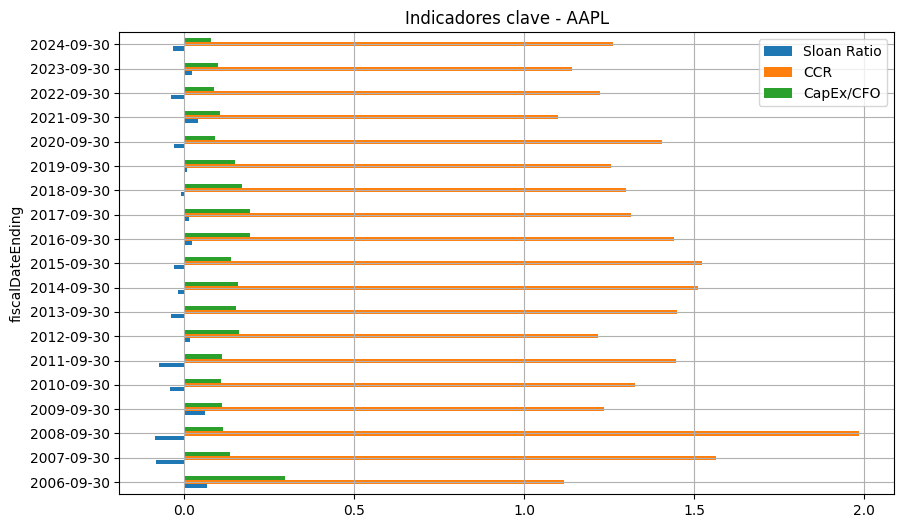

In [10]:
df_completo[['Sloan Ratio', 'CCR', 'CapEx/CFO']].plot(kind='barh', figsize=(10,6), title=f"Indicadores clave - {ticker}")
plt.grid(True)

In [11]:
def diagnostico_ganancias(df, ticker):
    year = df.index[-1]
    sloan = df.loc[year, 'Sloan Ratio']
    ccr = df.loc[year, 'CCR']
    mscore = df.loc[year, 'Beneish M-Score']

    resumen = f"""Diagnóstico Financiero para {ticker} - {year}
▪ Sloan Ratio: {sloan:.2f} {'!!' if sloan > 0.15 else '[Bueno]'}
▪ Cash Conversion Ratio: {ccr:.2f} {'!!' if ccr < 0.8 else '[Bueno]'}
▪ Beneish M-Score: {mscore:.2f} {'!!' if mscore > -1.78 else '[Bueno]'}
"""
    print(resumen)


In [12]:
diagnostico_ganancias(df_completo, ticker)

Diagnóstico Financiero para AAPL - 2024-09-30
▪ Sloan Ratio: -0.03 [Bueno]
▪ Cash Conversion Ratio: 1.26 [Bueno]
▪ Beneish M-Score: -4.84 [Bueno]



In [13]:
import matplotlib.pyplot as plt

def graficar_tendencias(df, ticker):
    plt.figure(figsize=(12,6))
    df[['Sloan Ratio', 'CCR', 'CapEx/CFO']].plot(marker='o', title=f"Calidad de Ganancias - {ticker}", figsize=(12,6))
    plt.axhline(0.1, color='gray', linestyle='--', label="Límite Sloan sano (0.10)")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    df['Beneish M-Score'].plot(marker='o', figsize=(12,5), title=f"Beneish M-Score - {ticker}")
    plt.axhline(-1.78, color='red', linestyle='--', label="Umbral de alerta")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [14]:
def diagnostico_tendencia(df, ticker):
    ultimos = df.tail(3)
    print(f"Tendencia de {ticker} (últimos 3 años)")
    print(f"▪ Sloan Ratio: ({ultimos['Sloan Ratio'].iloc[0]:.2f} -> {ultimos['Sloan Ratio'].iloc[-1]:.2f})")
    print(f"▪ CCR: ({ultimos['CCR'].iloc[0]:.2f} -> {ultimos['CCR'].iloc[-1]:.2f})")


<Figure size 1200x600 with 0 Axes>

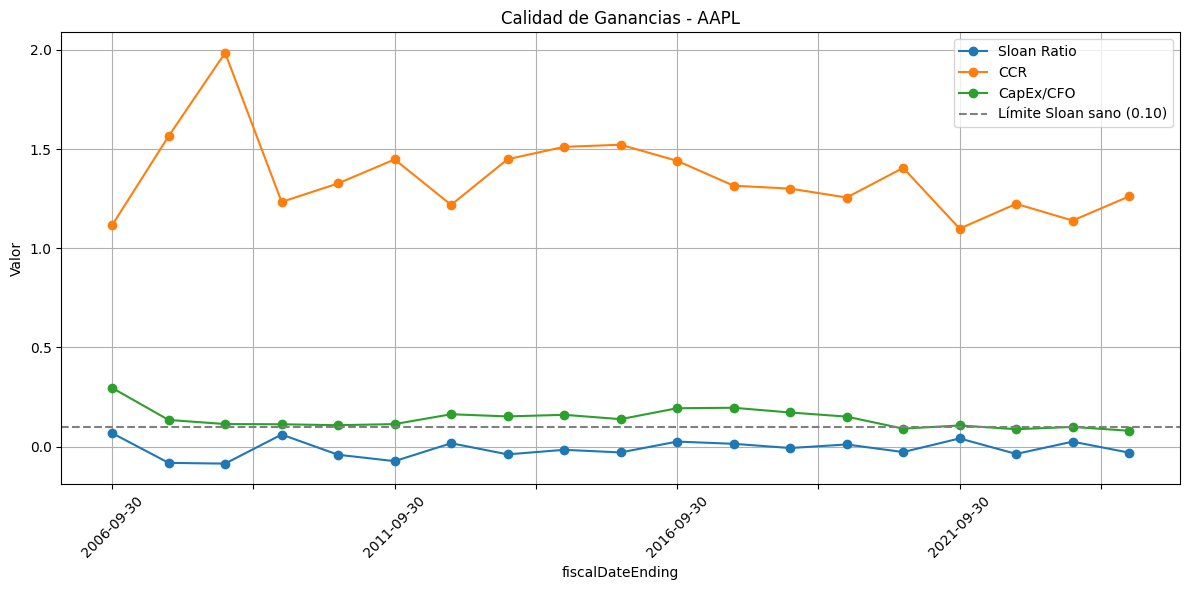

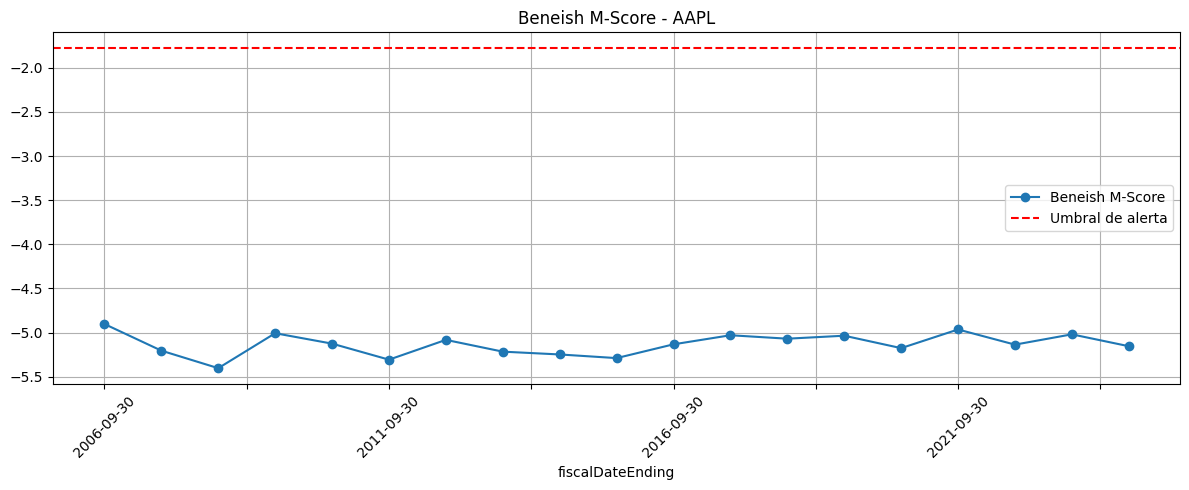

Tendencia de AAPL (últimos 3 años)
▪ Sloan Ratio: (-0.04 -> -0.03)
▪ CCR: (1.22 -> 1.26)


In [15]:
df_multi = preparar_datos_avanzado(ticker)
graficar_tendencias(df_multi, ticker)
diagnostico_tendencia(df_multi, ticker)
